In this Notebook i expiriment with facial detectection and recognition. I use the face_recognition library which is a python library that is designed to perform high-accuracy face detection/recognition tasks.  It was built on top of dlib, a C++ toolkit for machine learning. The library uses a pre-trained deep neural network for making face embeddings. 
Dlib offers several different algorithms including SVM, HOG, CNN, K-Nearest Neighbors and Decision trees. The library’s default for detecting faces is the Histogram of Oriented Gradients (HOG), while the embedding gets done by a ResNet-based CNN model. The dataset i have used for the notebook is called Labeled Faces in the Wild (LFW). The LFW dataset is a dataset designed for facial recognition and face verification programs and it contains 13000 labeled images of 5000 individuals (Politicians, artists and other celebrities).


1. Data preparation

Before i can use any of the images in the dataset i want some more information on how many images each individual has in this dataset. I do this by importing the dataset from the sklearn.datasets library and plotting the amount on a bar chart, since there are a lot of individuals i only plot 50 individuals with the highest amount of images. A quick glance at the chart will let you know that amount of images per person is varied and some outliers have way more images than others. 5 people have more than 100 images which is considerably more than most users have. 

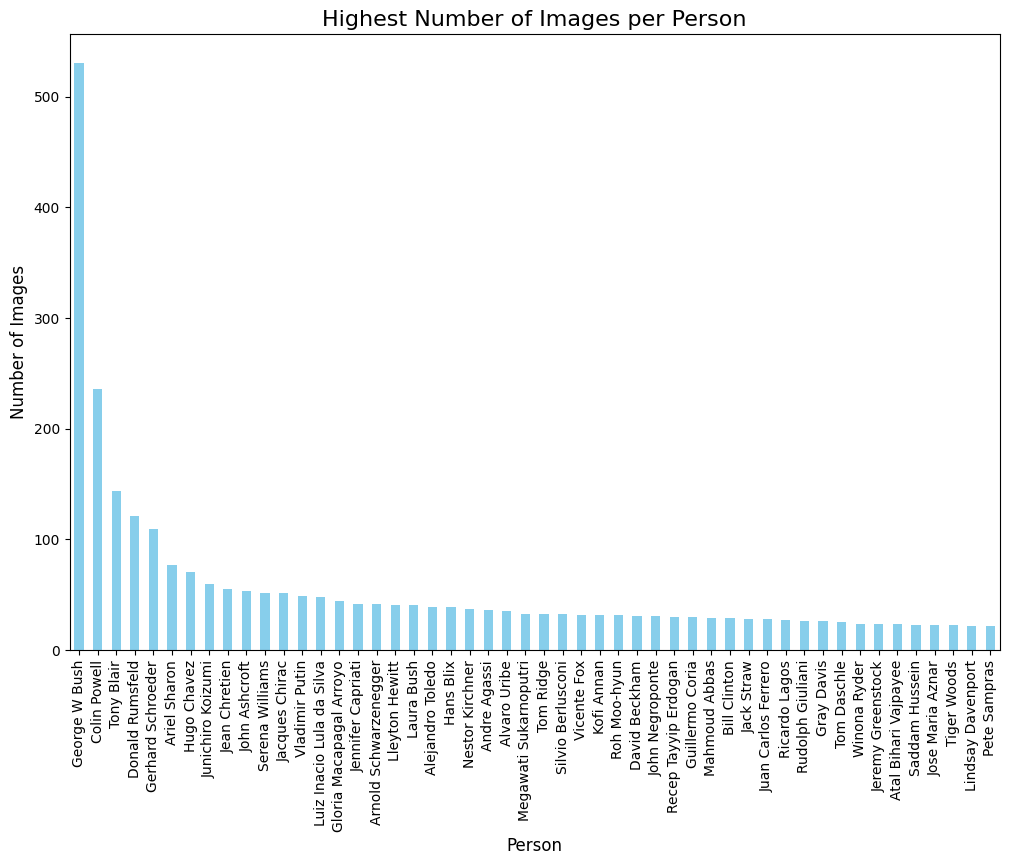

In [1]:
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_lfw_people
import pandas as pd

lfw_people = fetch_lfw_people(min_faces_per_person=1)

df = pd.DataFrame(lfw_people.target, columns=['person_id'])

image_counts = df['person_id'].value_counts().sort_values(ascending=False)

person_names = lfw_people.target_names

image_counts.index = person_names[image_counts.index]

plt.figure(figsize=(12, 8))
image_counts.head(50).plot(kind='bar', color='skyblue')
plt.title("Highest Number of Images per Person", fontsize=16)
plt.xlabel('Person', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.xticks(rotation=90)
plt.show()

To get some more insight i plotted the whole dataset into a histogram and used a Logarithmic scale to visualise the skewed data better. The Logarithmic scale increases by factors of 10. Meaning the 10(0) mark represents 1 individual, 10(1) mark represents 10 individuals, 10(2) mark 100 individuals and 10(3) marks 1000 individuals. In the historgram you can thus see that about 5000 individuals have a number of images between 1 - 50. I added a table to see the precise amounts in each range. 

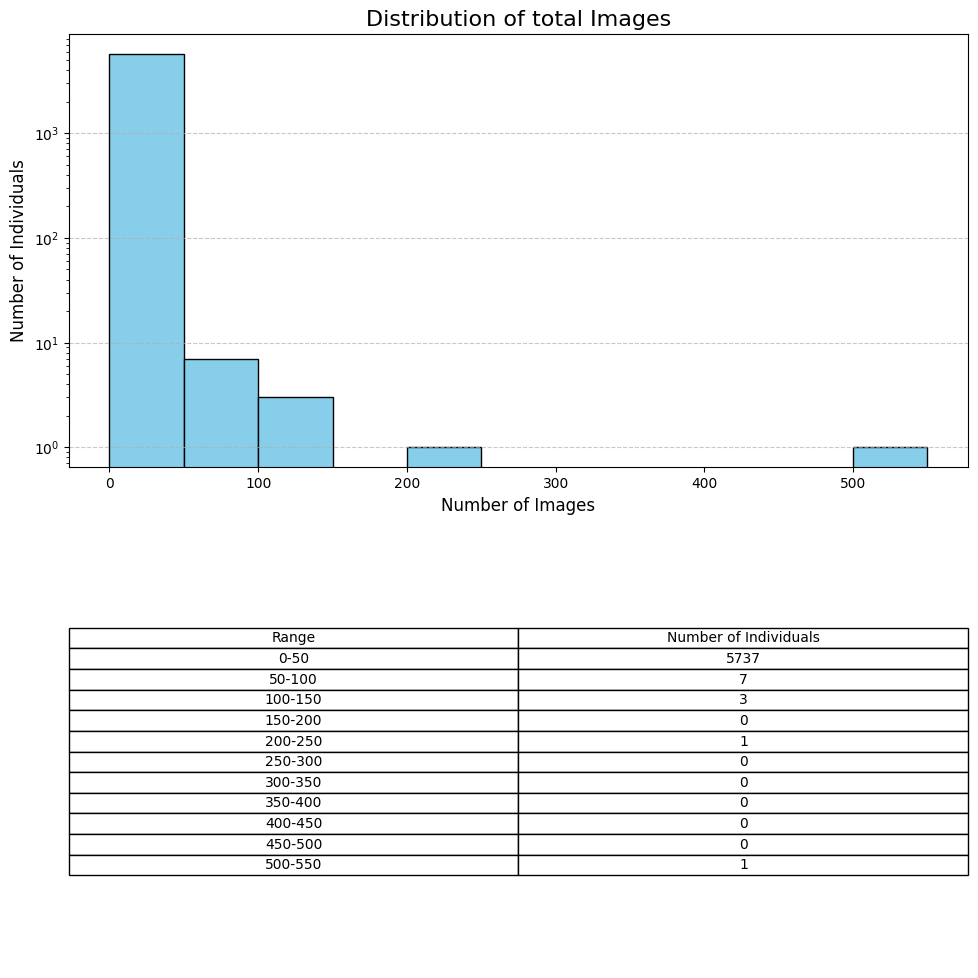

In [2]:
bins = range(0, 600, 50)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

hist, bin_edges, patches = ax1.hist(image_counts, bins=bins, color='skyblue', edgecolor='black')
ax1.set_title("Distribution of total Images", fontsize=16)
ax1.set_xlabel("Number of Images", fontsize=12)
ax1.set_ylabel("Number of Individuals", fontsize=12)
ax1.set_yscale('log') 
ax1.grid(axis='y', linestyle='--', alpha=0.7)

bin_labels = [f'{int(bin_edges[i])}-{int(bin_edges[i+1])}' for i in range(len(bin_edges) - 1)]  # Ensure integer formatting
table_data = [[bin_labels[i], f'{int(hist[i])}'] for i in range(len(hist))]

ax2.axis('off') 
table = ax2.table(cellText=table_data, colLabels=["Range", "Number of Individuals"], loc="center", cellLoc="center")

plt.tight_layout(pad=1.5)

plt.show()

To gain more insight about the spread of the distribution with the most individuals i zoomed in further on the 0-50 range. Again i used Logarthimic scale to handle the visualisation better and added a table to easily see the exact amounts. Most individuals seem to fall under the 1-10 range (1 since this is the minimum). To see which amount of images is most common for an individual to have i calculated the mode of the dataset. Which returns the most common amount of images for a person to have is 1 image (the minimum) as this happens 4069 times.  

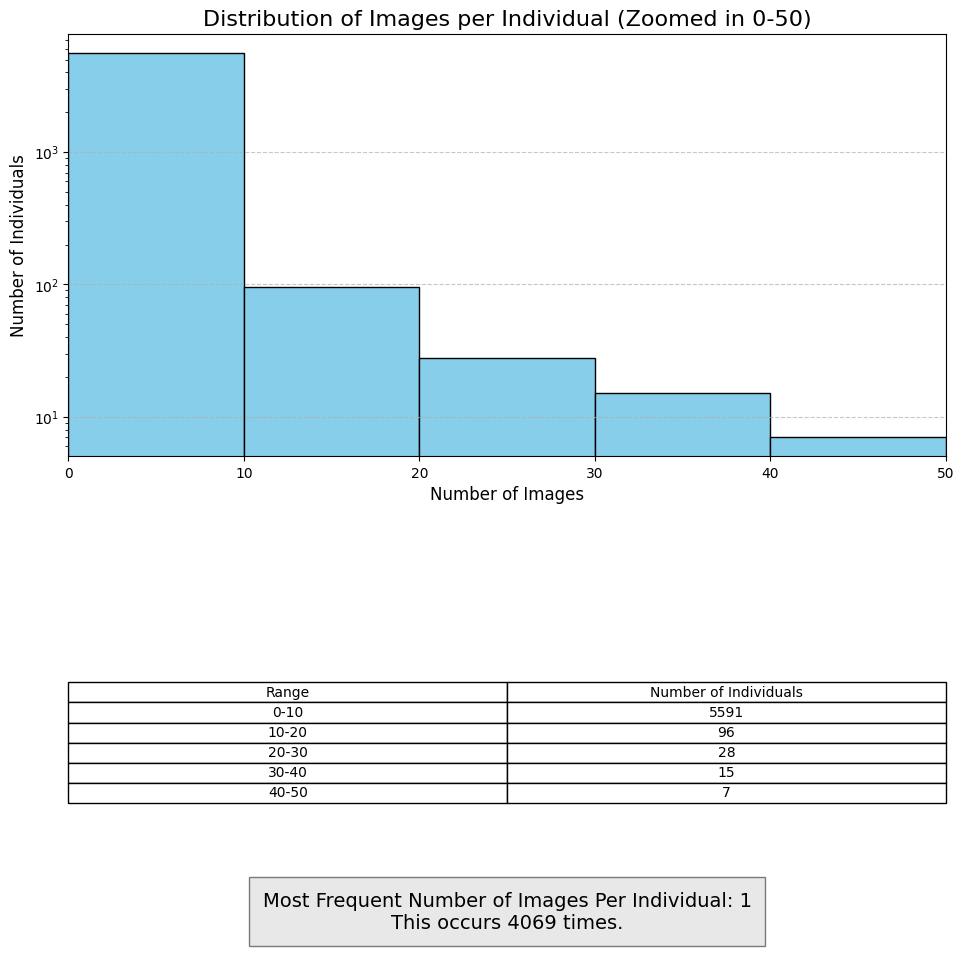

In [3]:
bins = range(0, 51, 10)  
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

hist, bin_edges, patches = ax1.hist(image_counts, bins=bins, color='skyblue', edgecolor='black')
ax1.set_title("Distribution of Images per Individual (Zoomed in 0-50)", fontsize=16)
ax1.set_xlabel("Number of Images", fontsize=12)
ax1.set_ylabel("Number of Individuals", fontsize=12)
ax1.set_yscale('log') 
ax1.set_xlim(0, 50) 
ax1.grid(axis='y', linestyle='--', alpha=0.7)

bin_labels = [f'{int(bin_edges[i])}-{int(bin_edges[i+1])}' for i in range(len(bin_edges) - 1)]
table_data = [[bin_labels[i], f'{int(hist[i])}'] for i in range(len(hist))]

ax2.axis('off') 
table = ax2.table(cellText=table_data, colLabels=["Range", "Number of Individuals"], loc="center", cellLoc="center")

mode_value = image_counts.mode()[0]
mode_count = (image_counts == mode_value).sum()

ax2.text(0.5, 0.1, f'Most Frequent Number of Images Per Individual: {mode_value}\n'
                   f'This occurs {mode_count} times.',
         ha='center', va='center', fontsize=14, bbox={'facecolor': 'lightgray', 'alpha': 0.5, 'pad': 10})

plt.tight_layout(pad=2.0)
plt.show()

2. Importing Libaries & fetching the dataset

numpy: Used for numerical operations on arrays (like calculations, averaging, etc.).
face_recognition: Helps in detecting and recognizing faces in images.
os: Provides functions to interact with the operating system.
sklearn.datasets.fetch_lfw_people: Loads the LFW (Labeled Faces in the Wild) dataset, which contains images of people. Each image is labeled with the individuals name.
matplotlib.pyplot: Helps in plotting images and graphs for visualization.
random: Used to select randoms for selecting images from the dataset.

In this notebook i use the LFW Dataset from the sklearn.datasets library. The command lfw_people = fetch_lfw_people(min_faces_per_person=10, resize=0.6) sets a minimum amount of images per person so the model will work more accurately. As seen in the earlier histogram most users have 1 image. I set the minimum required images to 10 since i need to split the amount of images into a train and test set later. This minimum results in an amount of 158 individuals and a total images count of 4324.

Dataset loaded:
Images shape: (4324, 75, 56)
Amount of individuals: 158
Total images: 4324


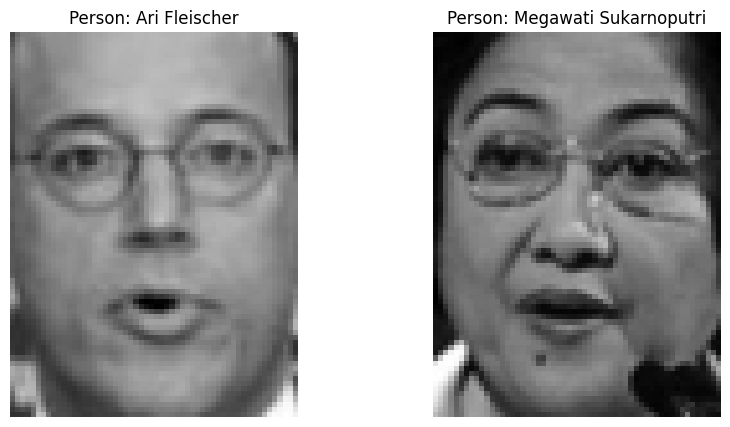

In [4]:
import numpy as np
import face_recognition
from sklearn.datasets import fetch_lfw_people
import matplotlib.pyplot as plt
import random

lfw_people = fetch_lfw_people(min_faces_per_person=10, resize=0.6)  

images = lfw_people.images 
labels = lfw_people.target 
target_names = lfw_people.target_names  

print("Dataset loaded:")
print(f"Images shape: {images.shape}")
print(f"Amount of individuals: {len(target_names)}")
print(f"Total images: {len(images)}")

random_indices = random.sample(range(len(images)), 2)

# Display two example images
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
for i, ax in enumerate(axes):
    img_index = random_indices[i]
    ax.imshow(images[img_index], cmap='gray')  
    ax.set_title(f"Person: {target_names[labels[img_index]]}")  
    ax.axis('off')

plt.show()

2. Extract face encodings and split dataset

train_test_split splits the dataset into training and testing subsets. 80% (3459 samples) of the data is used for training, and 20% is used for testing (865 samples).
stratify labels ensures that the distribution of labels is similar in both the training and testing sets, so each set has an equal representation of people ensuring better accuracy for the model. I print the label distribution to showcase that stratify labels works.

Since the dataset contains grayscaled images i first have to convert them to RGB as required for the face_recognition library.

The loop iterates over the training images and computes the encoding for each image (a numerical representation of the face).

The face_recognition.face_locations function detects face locations in the image to be used by the encoding function. 

The face_recognition.face_encodings function generates face encodings, which are numerical representations of faces. These encodings are high-dimensional feature vectors that summarize the important aspects of a face for recognition purposes.

In [5]:
from sklearn.model_selection import train_test_split

# Perform a stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(
    images, labels, test_size=0.2, random_state=42, stratify=labels
)

print(f"Number of training samples: {len(X_train)}")
print(f"Number of testing samples: {len(X_test)}")

# Count occurrences of each label in train and test sets
train_label_counts = np.bincount(y_train)
test_label_counts = np.bincount(y_test)

print("Training set label distribution:", train_label_counts)
print("Testing set label distribution:", test_label_counts)

train_encodings = []

for img, label in zip(X_train, y_train):
    img = (img * 255).astype(np.uint8)  # Convert to 8-bit image
    rgb_img = np.stack([img] * 3, axis=-1)  # Convert to RGB
    
    # Find face locations
    face_locations = face_recognition.face_locations(rgb_img)
    face_encodings = face_recognition.face_encodings(rgb_img, face_locations)
    
    # Map the numeric label to person's name
    person_name = target_names[label]  
    
    # Add encodings to the list, along with the corresponding name
    for encoding in face_encodings:
        if encoding is not None:  
            train_encodings.append((encoding, person_name))  

print(f"Total number of face encodings for training subset: {len(train_encodings)}")

if len(train_encodings) > 0:
    print(f"First encoding and label from training subset: {train_encodings[0]}")
else:
    print("No face encodings found in the training set.")


Number of training samples: 3459
Number of testing samples: 865
Training set label distribution: [ 15  10  31  28  17  29  12  16   9  10  10  61  34  19  23  14   8  12
  11  17  15   9  10 189   9  25  11  11  12  97  10  11  14  10  18 424
  87  35  10  10  21  24  13  18  31  10  11  10  12  57   8  16  22  10
  41   8  11   9   8   8  14  44   8  10  17  33  10  17  19  16   9  10
   9  42  14  15  14  25   9  14  15  18  22  15  12  48  10  11   9  26
  14  33  18  33  10  38  11  23   9  26  12  16  10  14   9   8  12   8
  12  18  30   9  15  12   8  16   9   8  14  18  12  10  24  14  22   9
   8  14  11  26  10  21  18  10  41   9   9  26  14  12   9  18  15   8
  20   8  26  13   8 115  13  14  26  39   8  10  19  11]
Testing set label distribution: [  4   2   8   7   4   7   3   4   2   2   3  16   8   5   6   3   2   3
   3   4   4   2   3  47   2   6   3   3   3  24   3   3   4   3   4 106
  22   9   2   3   5   6   3   4   8   2   3   2   3  14   2   4   6   3
  11   2  

3. Average encodings for each person

In this section i perform a data aggregration step by grouping the encodings by person and turning these into an average. By doing this i create a more robust and reliable representation for the recognition of a person, if i were to only use 1 image where a user looks to the left the AI might not recognise the person if he looked to the right. To showcase if the average encoding gets generated i print the first 5 people with their avarge encoding and the total amount of people with an average encoding. 

In [6]:
encodings_by_person = {}

for encoding, label in train_encodings:
    if label not in encodings_by_person:
        encodings_by_person[label] = []
    encodings_by_person[label].append(encoding)

# Compute the average encoding for each person
average_encodings = {}
for person_label, person_encodings in encodings_by_person.items():
    if len(person_encodings) > 0:
        # Convert list of encodings to numpy array and compute the average
        average_encodings[person_label] = np.mean(person_encodings, axis=0)

for person_label, avg_encoding in list(average_encodings.items())[:5]:
    print(f"Average encoding for {person_label}: {avg_encoding}")


Average encoding for Gerhard Schroeder: [-9.75134351e-02  3.48123036e-02  3.10146067e-02  4.96005159e-02
 -6.49679167e-02 -6.17048923e-02  6.54150337e-03 -1.21592946e-01
  4.07436982e-02 -8.95624463e-03  1.58153344e-01 -8.11098674e-02
 -2.36941342e-01 -6.91495788e-02 -1.84746220e-02  7.05481366e-02
 -9.44601027e-02 -1.04304084e-01 -1.29978234e-01 -8.37530998e-02
  2.41972865e-04 -4.10742439e-03 -6.97122063e-03 -2.07866303e-02
 -1.32299097e-01 -2.26190486e-01 -6.04339258e-02 -7.62045503e-02
  4.67001796e-02 -6.36968150e-02  4.56084313e-02  7.94128699e-02
 -2.60293743e-01 -1.23141813e-01  5.41232202e-02  8.87016521e-02
 -2.42018717e-02 -2.18996246e-02  2.37481365e-01 -2.40168572e-02
 -1.59085162e-01  2.11846120e-02  1.12848632e-01  2.59824288e-01
  2.10012793e-01  5.49971691e-03 -7.53597962e-02  2.46353148e-04
  1.40090808e-01 -2.97435254e-01  9.35287652e-02  1.51037078e-01
  1.85757286e-01  6.83309535e-02  1.25076730e-01 -1.31741491e-01
  4.58473703e-02  1.28155320e-01 -1.62057171e-01  

4. Comparing

Here i compare the new face encodings with the average encodings i computed for each person.
To identify which person a new face belongs to i use compute_distance which calculates the Euclidian distance between two encodings, the smaller the distance the more similair the encodings are. The Euclidian distance computes the straight-line distance between two points in a multi-dimensional space. In the notebook, each encoding is a multi-dimensional point (a vector) representing the features of a face, and the Euclidean distance states how similar or different two faces are. I compare the encoding of a face to all the average encodings to look for a match, if the Euclidian distance is below the threshold it means the system found a match.

Sometimes a test image has no detected face in them, these get sorrted out of the test set and added to a list. 
If the facial_recognition function detects a person incorrectly it gets added to the incorrect_recognition list and printed in the output.
When an encoding does get correctly matched with a person's average encoding it gets added to the correct_recognitions list, in the notebook 790 instances get recognised correctly by the function. Meaning out of the original 865 test images ~91.3% gets recognised correctly. 

In [7]:
import face_recognition

def get_first_image_by_name(name, images, labels, target_names):
    for img, label in zip(images, labels):
        if target_names[label] == name:
            return img
    return None 

true_labels = []  
predicted_labels = [] 
incorrect_details = [] 
undetected_faces = []  

def compute_distance(encoding1, encoding2):
    return np.linalg.norm(encoding1 - encoding2)

def recognize_face(face_encoding, average_encodings, threshold=0.6):
    min_distance = float("inf")
    recognized_person = None
    
    for person_name, avg_encoding in average_encodings.items():
        distance = compute_distance(face_encoding, avg_encoding)
        
        if distance < min_distance:
            min_distance = distance
            recognized_person = person_name  
    
    if min_distance > threshold:
        return None, min_distance
    
    return recognized_person, min_distance

correct_recognitions = 0
incorrect_recognitions_count = 0  

for i, img in enumerate(X_test):  
    img = (img * 255).astype(np.uint8)  # Convert to 8-bit image
    rgb_img = np.stack([img] * 3, axis=-1)  # Convert to RGB
    
    # Find face locations
    face_locations = face_recognition.face_locations(rgb_img)
    face_encodings = face_recognition.face_encodings(rgb_img, face_locations)
    
    if len(face_locations) == 0:
        undetected_faces.append(rgb_img)  
        true_labels.append(target_names[y_test[i]])  
        predicted_labels.append("Unknown")  
        continue  

    face_recognized = False  
    for face_encoding in face_encodings:
        label = target_names[y_test[i]]  
        recognized_person, distance = recognize_face(face_encoding, average_encodings)
        
        true_labels.append(label)

        if recognized_person is None:
            predicted_labels.append("Unknown") 
        else:
            predicted_labels.append(recognized_person)  
            face_recognized = True

        if recognized_person == label:
            correct_recognitions += 1
        elif recognized_person is not None:
            incorrect_recognitions_count += 1
            incorrect_details.append((rgb_img, label, recognized_person)) 

    if not face_recognized:
        incorrect_recognitions_count += 1
        incorrect_details.append((rgb_img, label, "Unknown")) 

print(f"Total number of undetected faces: {len(undetected_faces)}")
print(f"Total correct recognitions: {correct_recognitions}")
print(f"Total incorrect recognitions: {incorrect_recognitions_count}")


Total number of undetected faces: 70
Total correct recognitions: 790
Total incorrect recognitions: 5


In the code section below i take a look at the incorrectly recognized persons so i can evaluate if these people actually look alike or if there are other factors at play. At first glance the people might not look entirely alike, some have different skin colours and very different facial feautures. But backgrounds might play a factor here too. Michael Schumacher and Lance Armstrong are both athletes and in most photographs of them they both were caps which might distort the facial_recognition results. 

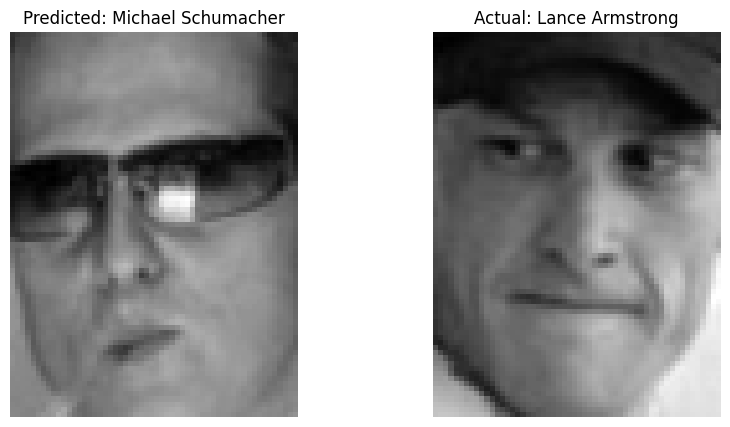

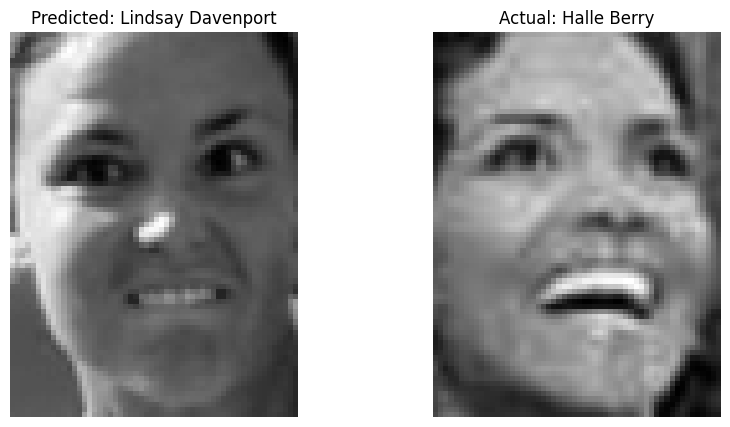

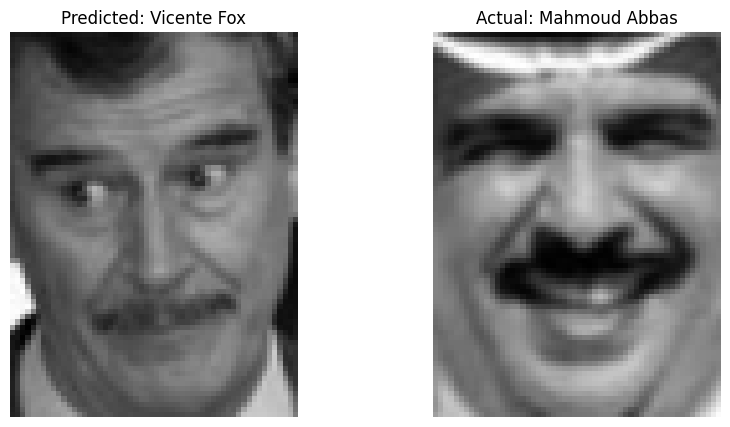

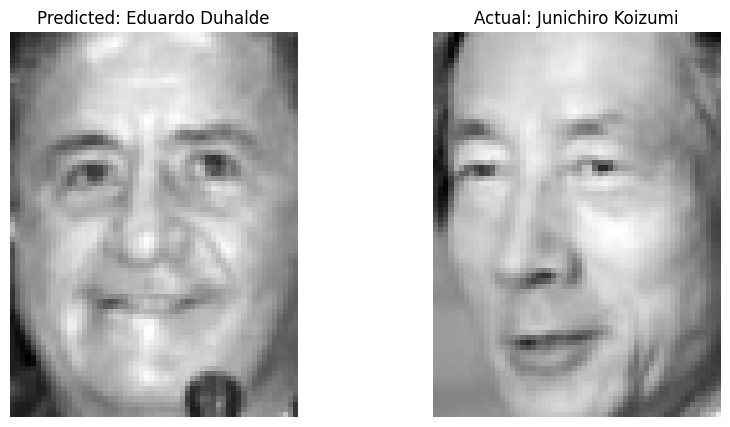

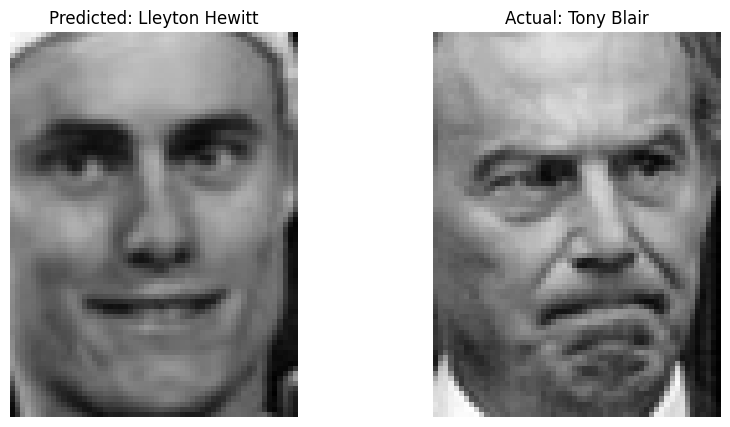

In [8]:
import matplotlib.pyplot as plt

def get_first_image_by_name(name, images, labels, target_names):
    for img, label in zip(images, labels):
        if target_names[label] == name:
            return img
    return None  

for rgb_img, actual_person, recognized_person in incorrect_details:
    actual_img = get_first_image_by_name(actual_person, X_test, y_test, target_names)

    predicted_img = None
    if recognized_person != "Unknown":  
        for img, label in zip(X_test, y_test):
            if target_names[label] == recognized_person:
                predicted_img = img
                break


    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    if predicted_img is not None:
        axes[0].imshow(predicted_img, cmap='gray')
        axes[0].set_title(f"Predicted: {recognized_person}")
    else:
        axes[0].imshow(np.zeros_like(X_test[0]), cmap='gray')  
        axes[0].set_title("Predicted: None")

    if actual_img is not None:
        axes[1].imshow(actual_img, cmap='gray')
        axes[1].set_title(f"Actual: {actual_person}")
    else:
        axes[1].imshow(np.zeros_like(X_test[0]), cmap='gray')  
        axes[1].set_title("Actual: Unknown")

   
    for ax in axes:
        ax.axis("off")
    plt.show()


I visualised more images of Lance Armstrong and Michael Schumacher to see if they look alike in other pictures. There seem to be some similarities as they often wear caps and have some similar facial features.    

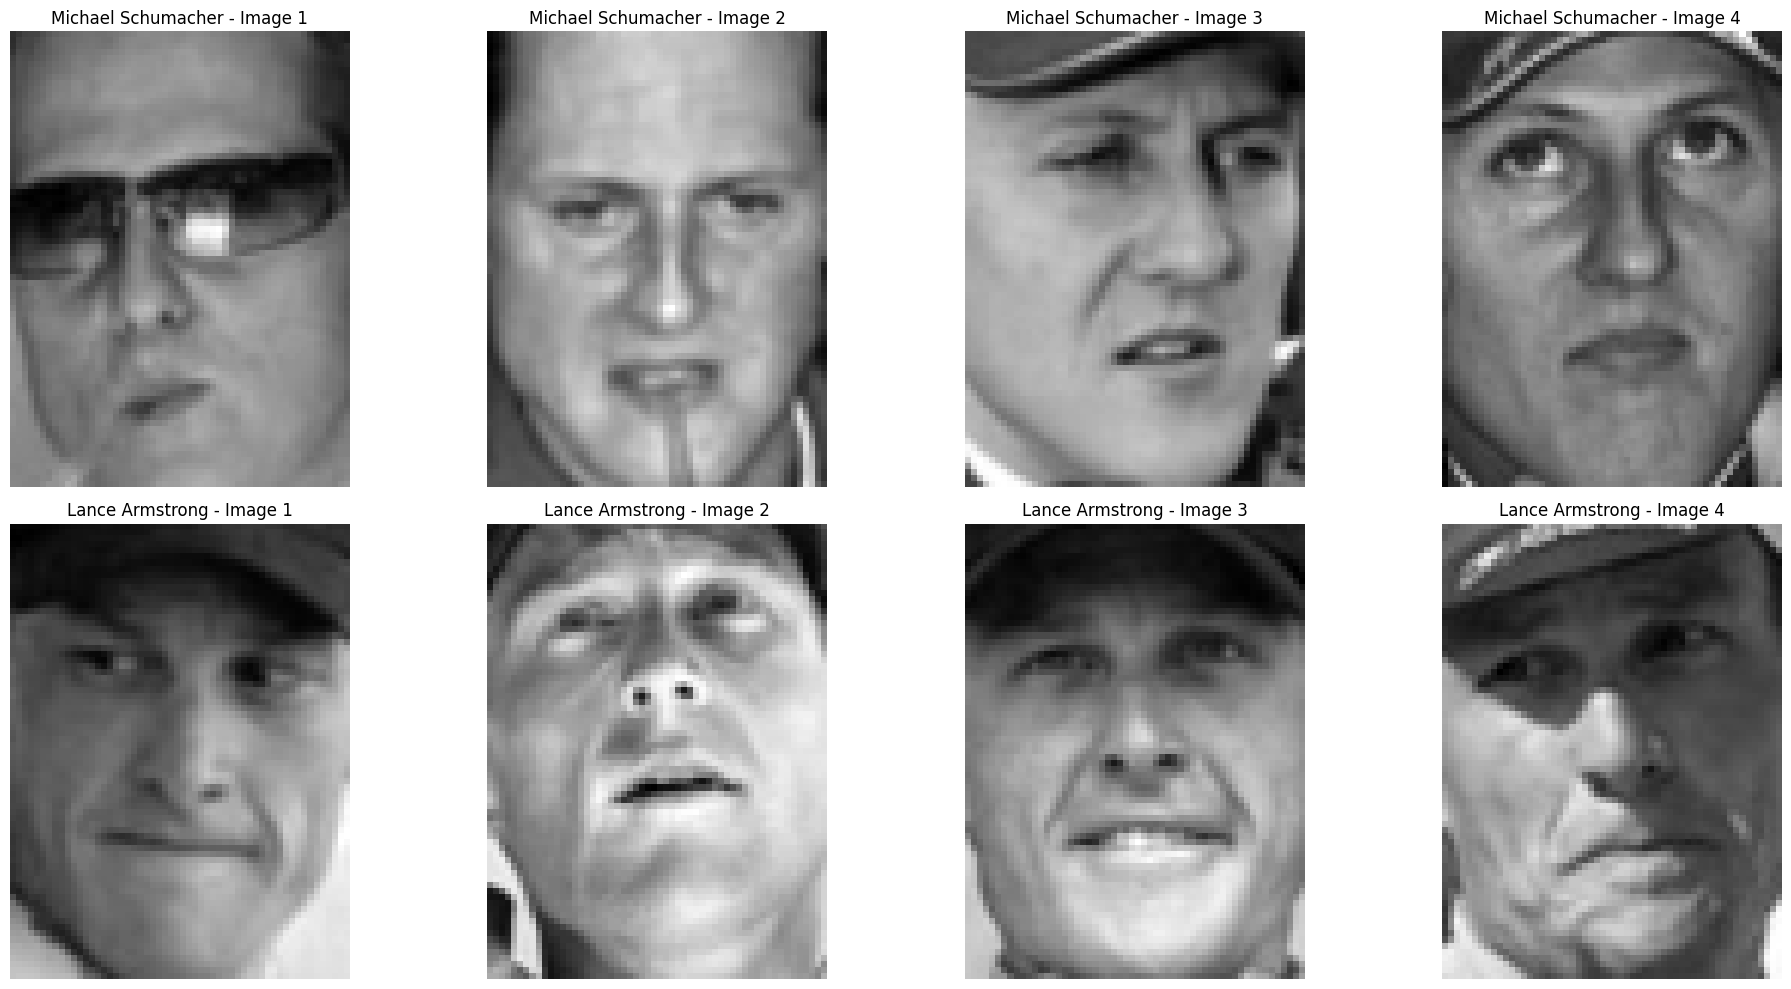

In [19]:
def display_images_for_comparison(names, images, labels, target_names):
    person_images = {name: [] for name in names}

    for img, label in zip(images, labels):
        person_name = target_names[label]
        if person_name in names:
            person_images[person_name].append(img)

    max_images = max(len(images) for images in person_images.values())

    fig, axes = plt.subplots(len(names), max_images, figsize=(5 * max_images, 5 * len(names)))

    if len(names) == 1:
        axes = [axes]

    for row, name in enumerate(names):
        images = person_images[name]
        for col in range(max_images):
            ax = axes[row][col] if max_images > 1 else axes[row]
            
            if col < len(images):
                ax.imshow(images[col], cmap='gray')
                ax.axis("off")
                ax.set_title(f"{name} - Image {col + 1}")
            else:
                ax.axis("off") 

    plt.tight_layout()
    plt.show()

display_images_for_comparison(
    ["Michael Schumacher", "Lance Armstrong"],
    X_test,  
    y_test,  
    target_names  
)

The pie chart below is an easy way to quickly glance at how effective the model is. 91.3% of the encodings get recognised correctly while only 0.6% gives incorrect recognitions. The problem with the 8.1% of images not having any face in them could easily be solved by implementing a set limit of face detected images when registering in a real-world application.

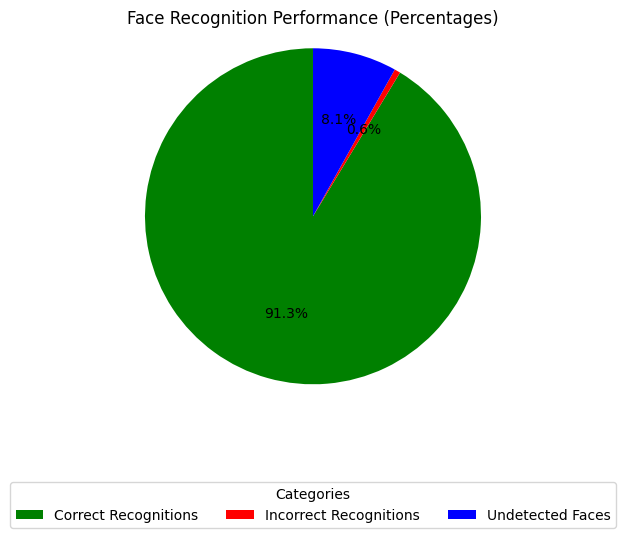

In [15]:
total_images = correct_recognitions + incorrect_recognitions_count + len(undetected_faces)

correct_percentage = (correct_recognitions / total_images) * 100
incorrect_percentage = (incorrect_recognitions_count / total_images) * 100
undetected_percentage = (len(undetected_faces) / total_images) * 100

categories = ['Correct Recognitions', 'Incorrect Recognitions', 'Undetected Faces']
percentages = [correct_percentage, incorrect_percentage, undetected_percentage]
colors = ['green', 'red', 'blue']

wedges, texts, autotexts = plt.pie(percentages, autopct='%1.1f%%', colors=colors, startangle=90)

plt.legend(wedges, categories, title="Categories", loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3)

plt.title('Face Recognition Performance (Percentages)')

plt.axis('equal')

plt.show()

5. Model Evaluation

The display_images_in_rows function displays some images with undetected faces. I do this to look for certain patterns in the images where no face can be seen. Almost all images are slightly turned, very zoomed in or have some obstruction in their face like hair or objects. 

After evaluation the model retains an accuracy of 91.33%, which seems reasonably safe considering in an actual integration of this model the encodings will be stored on the user's device, so the chance that a different person trying to unlock your device with their face is succesfull is very low.  

The classification report prints the precision, recall, F1-Score and the Support (amount of occurences of the class). Abdullah Gul has a 100% precision meaning that it always predicted Abdullah correctly. The recall means that 75% of the Abdullah instances in the dataset were correctly identified by the model and 25% failed to identify Abdullah. This results in a F1-score of 0.86 which is quite good.
In total the model scores an accuracy of 91% meaning most of the predictions were correct. 
The Macro average states the average performance for the Precision, recall and F1-score of all individuals.
The Weighted average is an adjusted average of performance since some classes have considerably more images in the dataset. Both seem to score a high number.     

                           precision    recall  f1-score   support

             Abdullah Gul       1.00      0.75      0.86         4
             Adrien Brody       1.00      1.00      1.00         2
         Alejandro Toledo       1.00      1.00      1.00         8
             Alvaro Uribe       1.00      0.86      0.92         7
          Amelie Mauresmo       1.00      1.00      1.00         4
             Andre Agassi       1.00      0.86      0.92         7
             Andy Roddick       1.00      1.00      1.00         3
           Angelina Jolie       1.00      1.00      1.00         4
              Ann Veneman       1.00      1.00      1.00         2
          Anna Kournikova       1.00      0.50      0.67         2
            Ari Fleischer       1.00      1.00      1.00         3
             Ariel Sharon       1.00      1.00      1.00        16
    Arnold Schwarzenegger       1.00      0.88      0.93         8
     Atal Bihari Vajpayee       1.00      0.80      0.89     

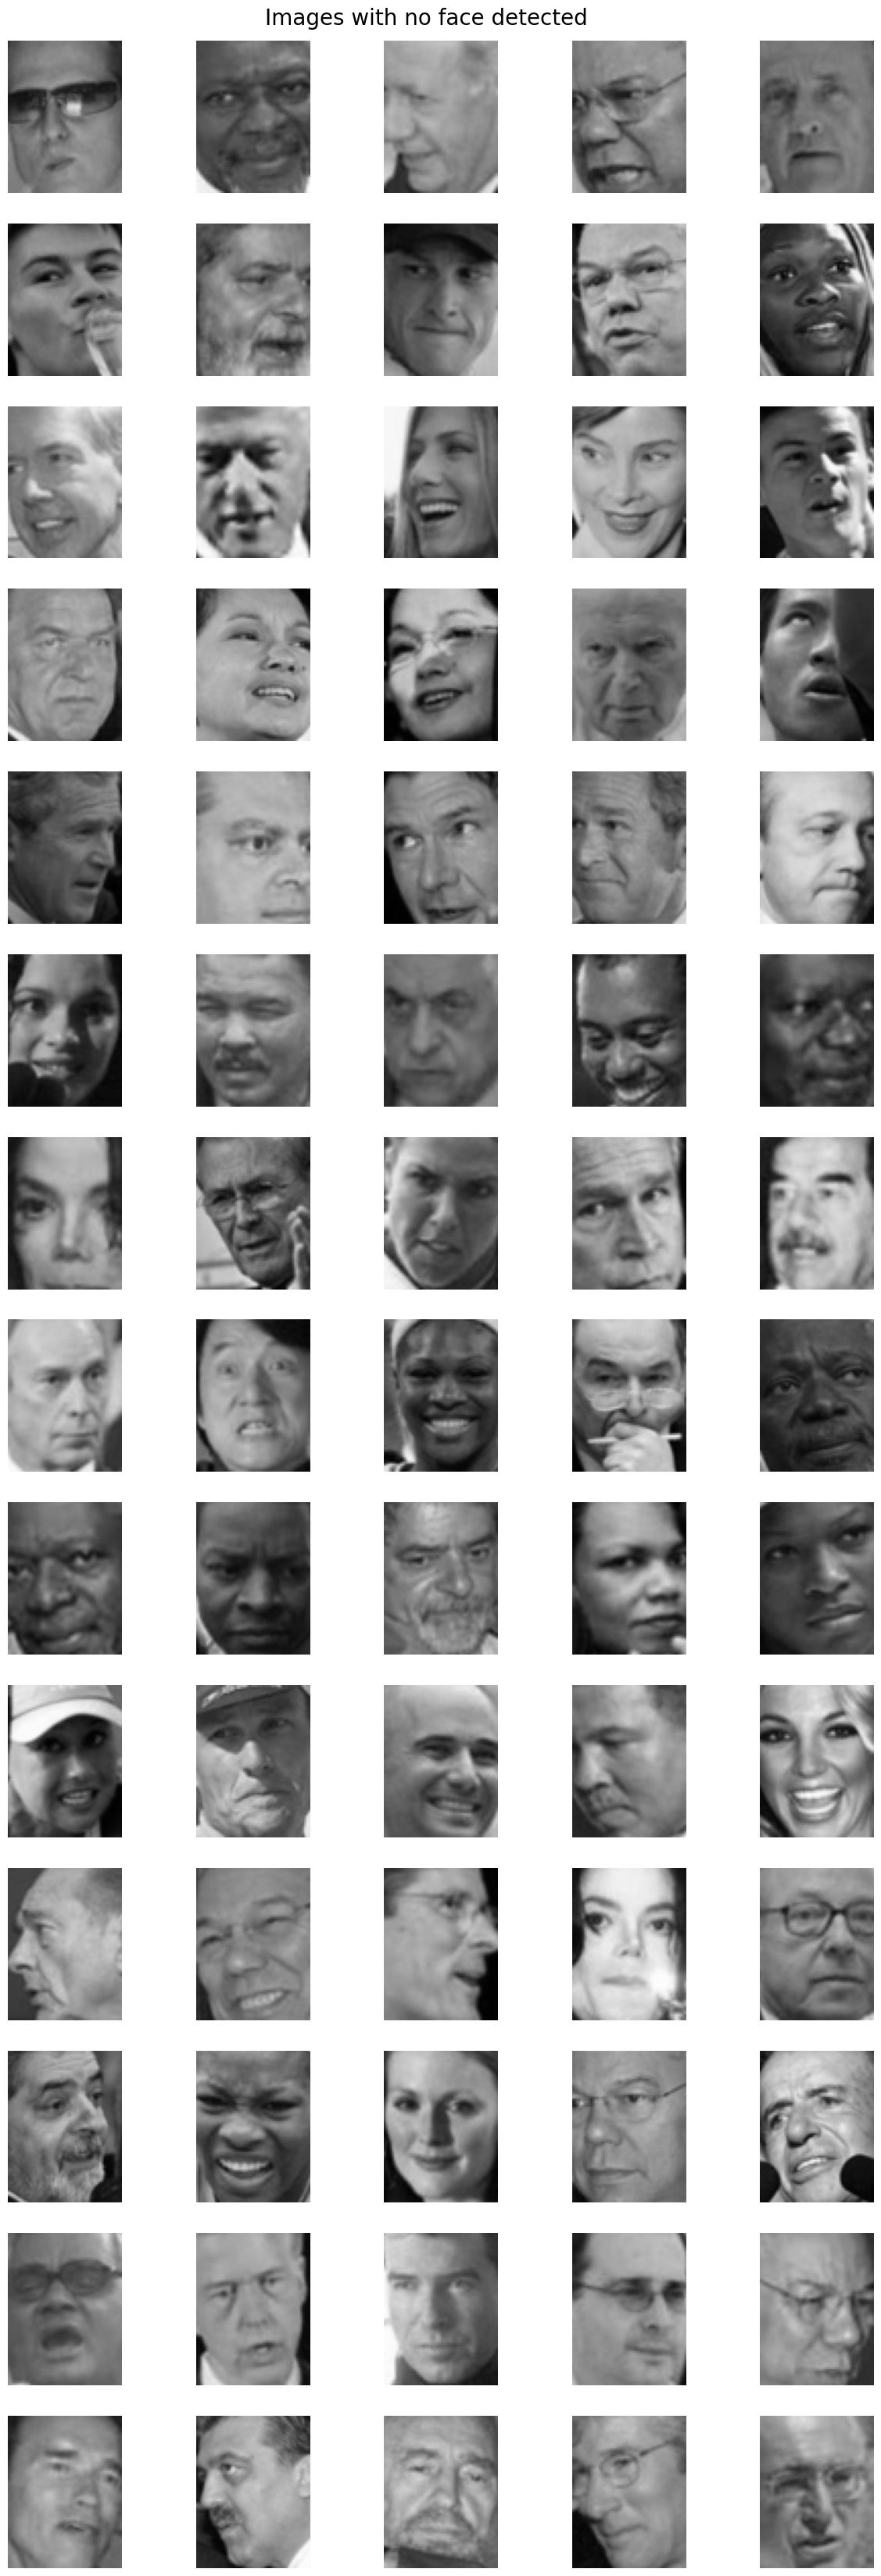

In [16]:
from sklearn.metrics import classification_report
    

report = classification_report(
    true_labels,
    predicted_labels,
    target_names=list(target_names) + ["Unknown"],
    zero_division=0
)
print(report)

def display_images_in_rows(images, num_cols=5):
    num_images = len(images)
    num_rows = (num_images + num_cols - 1) // num_cols  
    
    plt.figure(figsize=(num_cols * 3, num_rows * 3))  
    plt.suptitle("Images with no face detected", fontsize=20, y=0.89)

    for i, img in enumerate(images):
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(img)
        plt.axis('off')
    
    plt.show()

display_images_in_rows(undetected_faces)


Finally i generate a confusion matrix to show how the models predictions match up with the true labels. Since i have too many individuals i cannot properly visualise a confusion matrix without making the amount of indivuals smaller, so i have used 40 here. THe confusion matrix shows 40 names as rows and every row shows the made prediction for that person. In the matrix you can see that in the 103 instances the model predicted an encoding belonged to bush it was actually 103 times correct. You can also see that the model mistakenly identified an instance of Mahmoud Abbas as Vicente Fox one time.  

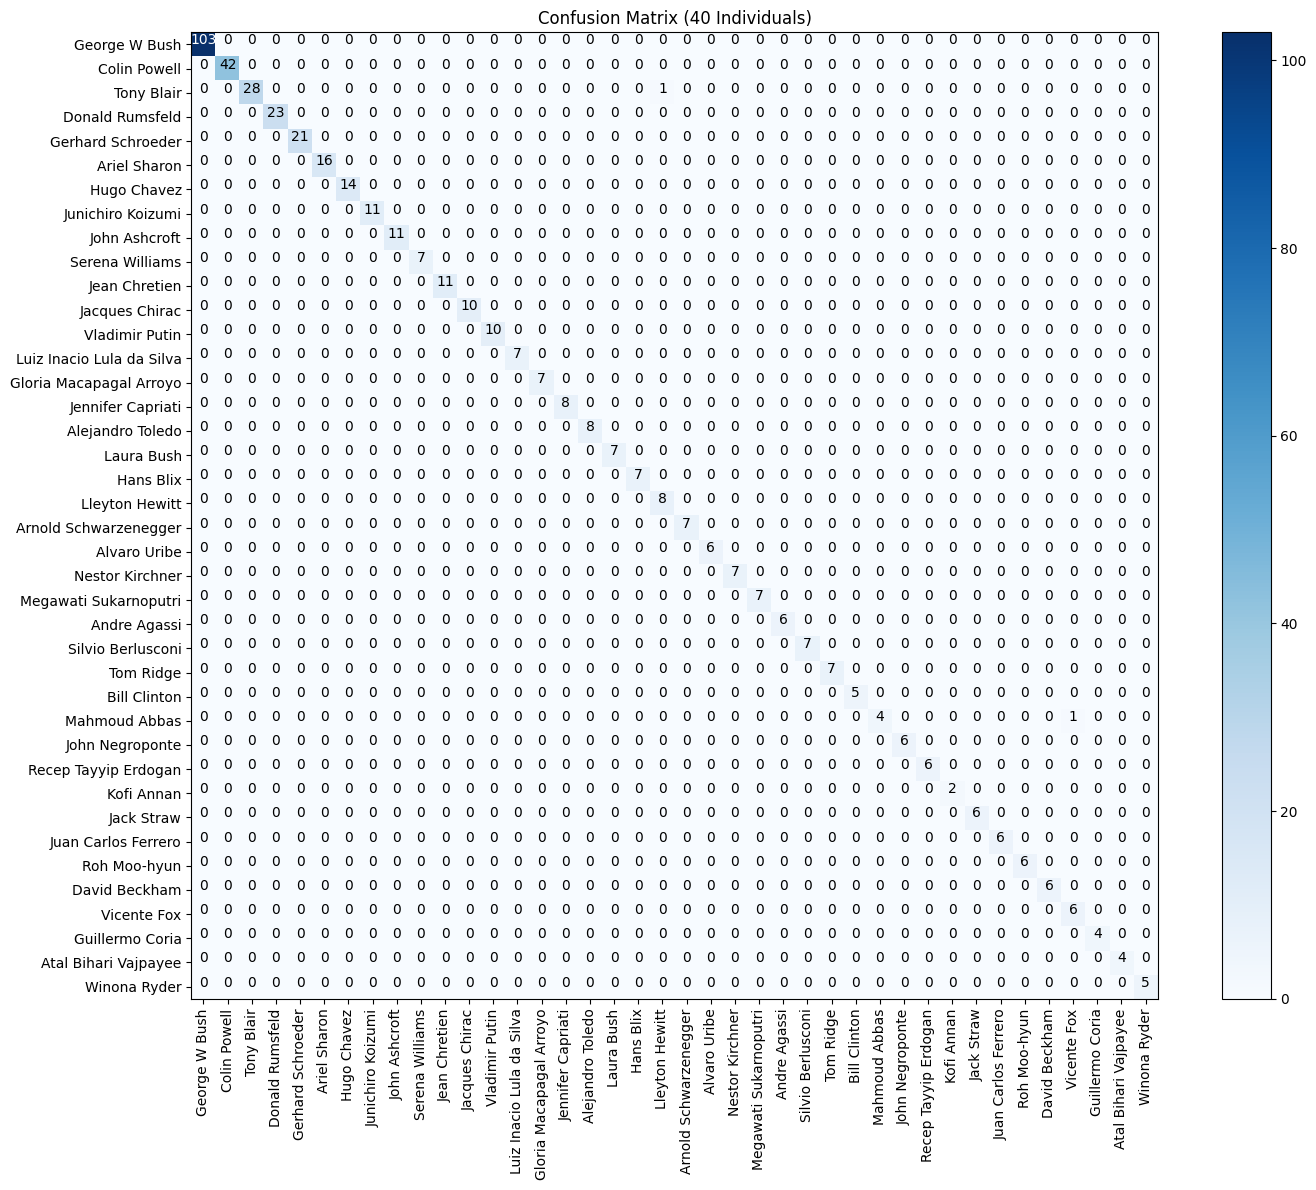

In [18]:
from sklearn.metrics import confusion_matrix

unique_labels = list(set(true_labels + predicted_labels))

subset_labels = sorted(unique_labels, key=lambda x: true_labels.count(x), reverse=True)[:40]

cm = confusion_matrix(true_labels, predicted_labels, labels=subset_labels)

plt.figure(figsize=(15, 12)) 
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix (40 Individuals)")
plt.colorbar()

tick_marks = np.arange(len(subset_labels))
plt.xticks(tick_marks, subset_labels, rotation=90)
plt.yticks(tick_marks, subset_labels)

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, f'{cm[i, j]}', horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()
